# Выбор жилья

## Общая информация по поиску

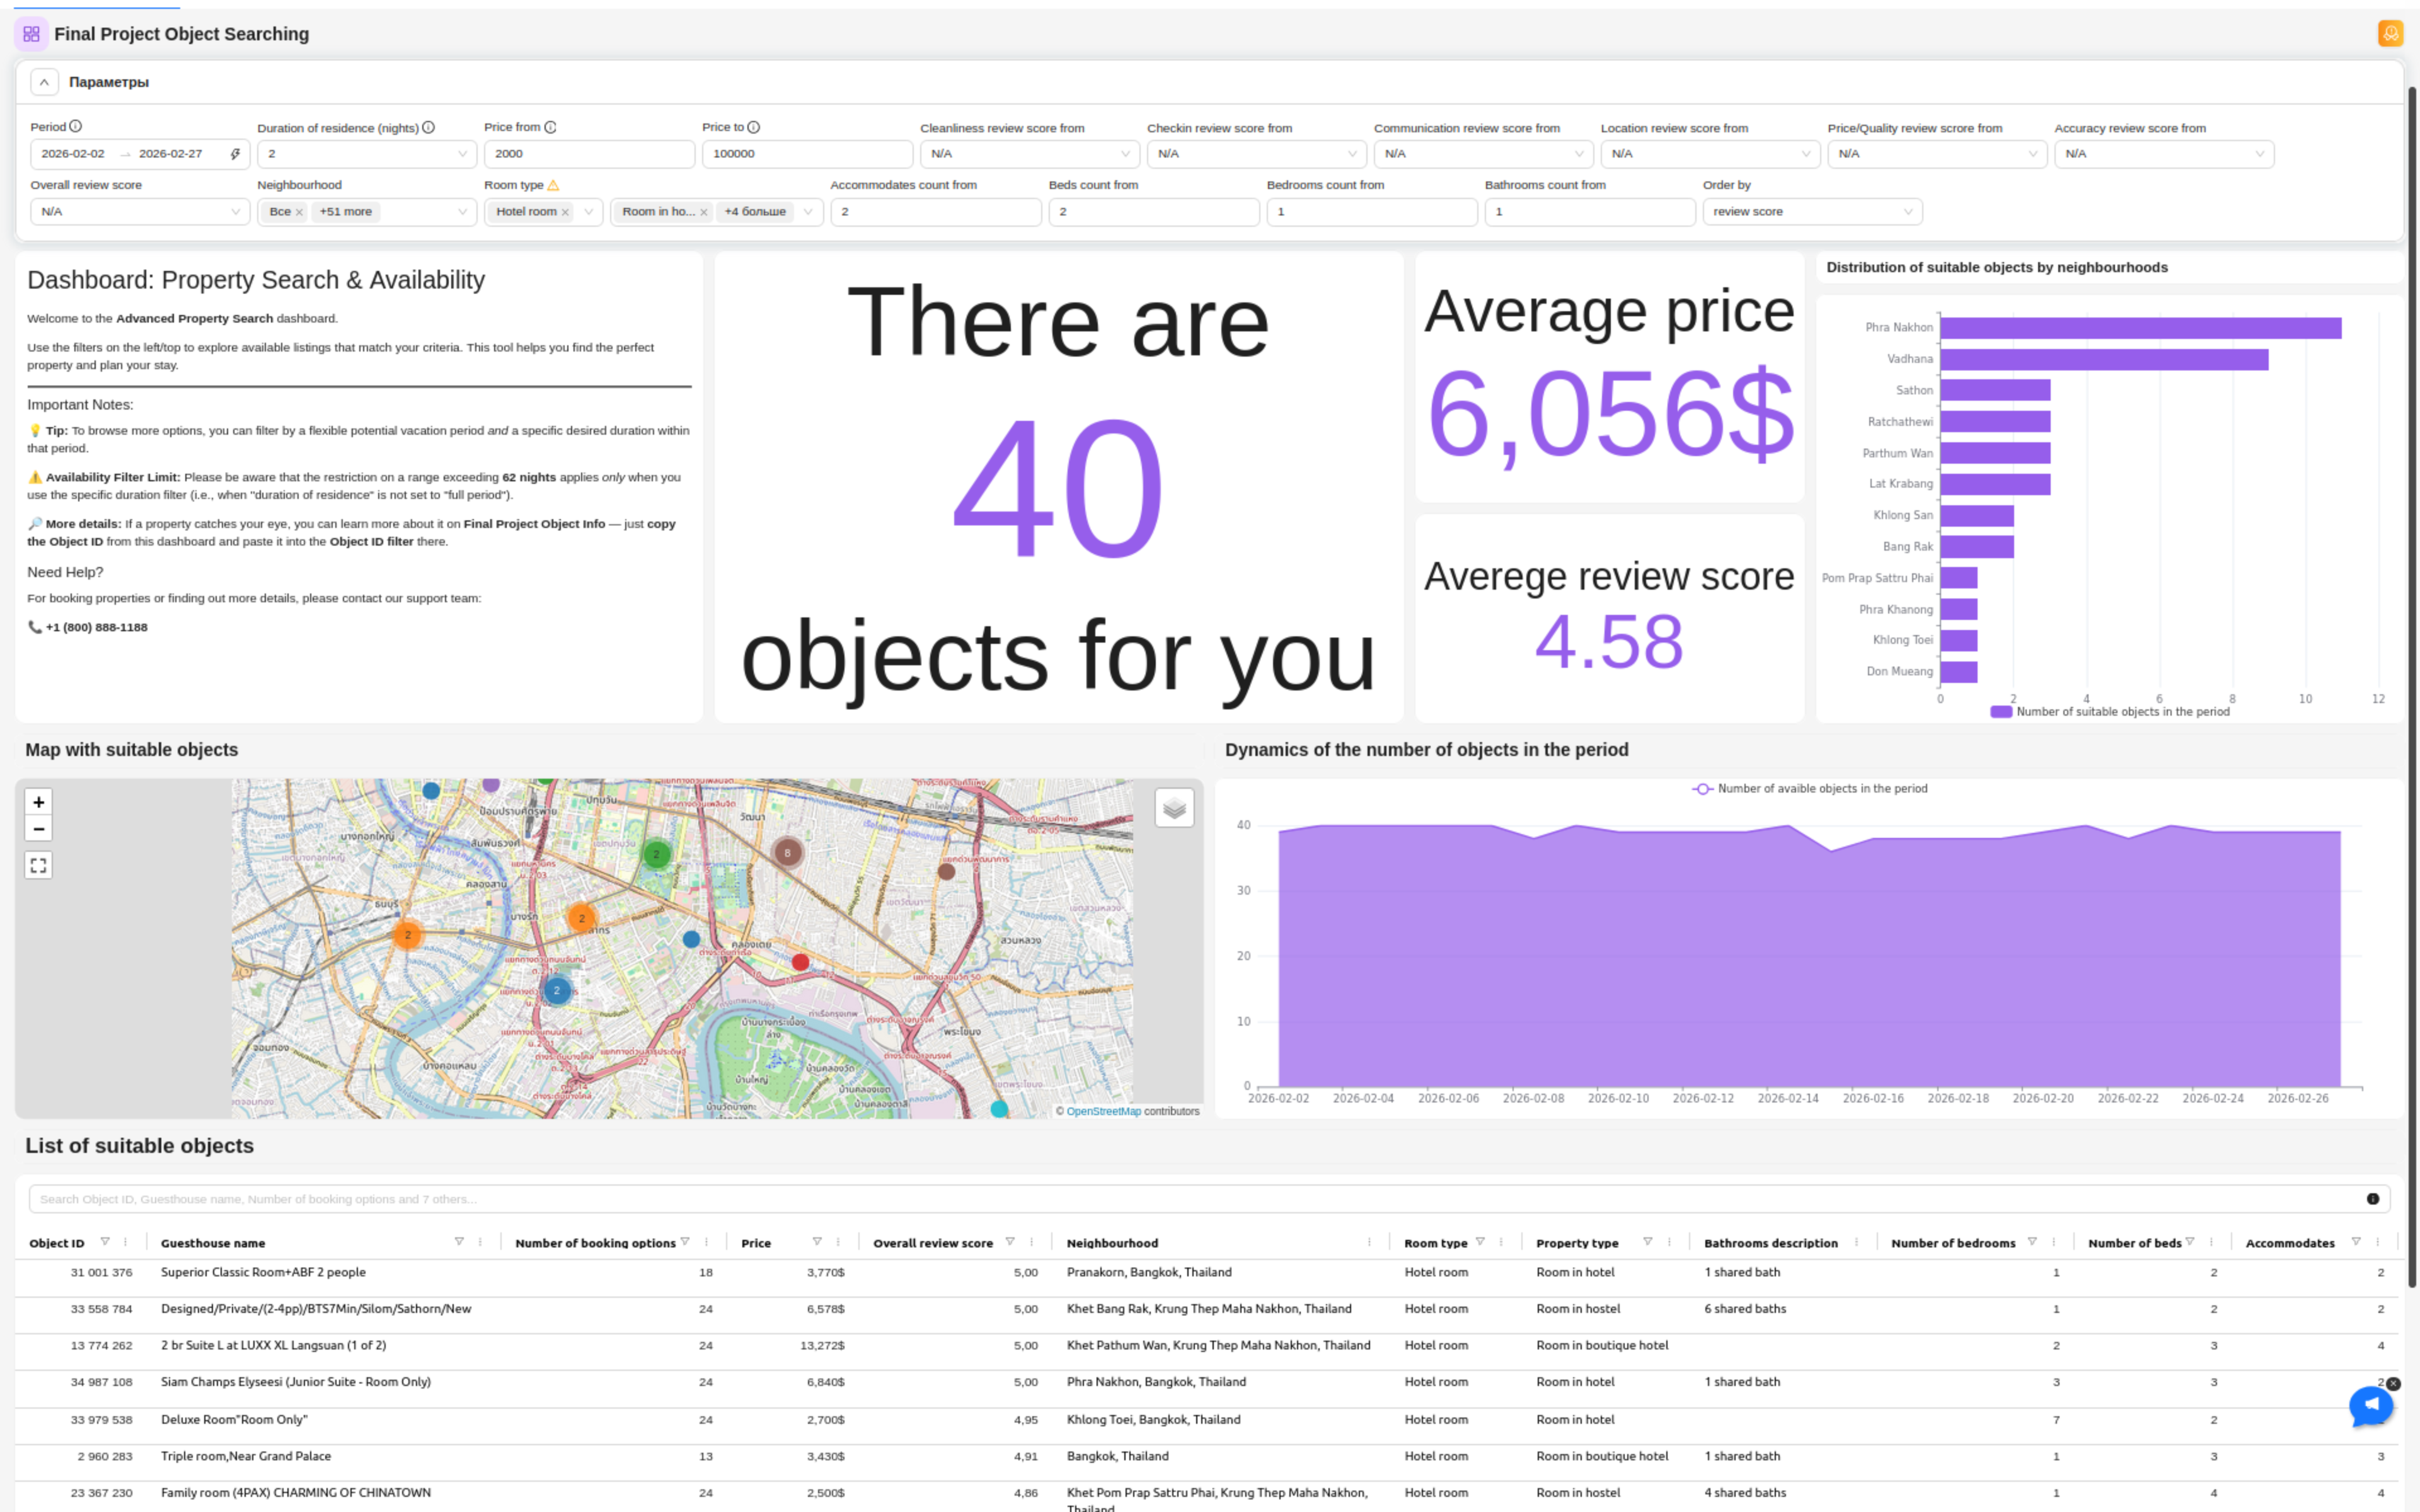

После информационного окошка, общая информация по поиску - это первое, что видит пользователь.

Общая информация включает:
* Количество подходящих объектов
* Средний ценник подходящих объектов
* Средний рейтинг подходящих объектов

![image.png](attachment:d720fb81-0e25-4464-9847-b0bfdd7d9fb4.png)

### SQL-запрос

```
WITH guard AS (
    SELECT
        ('{{ duration_days }}' = 'full period') AS is_full,
        -- dur всегда int (для full подставим 1, чтобы не ломать выражения)
        COALESCE(NULLIF('{{ duration_days }}', 'full period')::int, 1) AS dur,
        CASE
            -- guard только если НЕ full
            WHEN ('{{ duration_days }}' <> 'full period')
                 AND (('{{ period.end }}'::date - '{{ period.start }}'::date) > 62)
            THEN 1/0
            ELSE 1
        END AS ok
),

periods_dates AS (
    SELECT
        listing_id,
        calendar_date::date AS calendar_date,
        available
    FROM public_aaa.aaa_bi_calendar_bangkok
    WHERE TRUE
      AND calendar_date >= '{{ period.start }}'
      AND calendar_date < '{{ period.end }}'
      AND (SELECT ok FROM guard) = 1
),

-- full: весь период должен быть доступен
full_period_ok AS (
    SELECT
        listing_id,
        '{{ period.start }}'::date AS start_date
    FROM periods_dates
    GROUP BY listing_id
    HAVING
        COUNT(*) = (('{{ period.end }}'::date - '{{ period.start }}'::date))
        AND SUM(CASE WHEN available THEN 1 ELSE 0 END) = COUNT(*)
),

-- window: окна длиной N дней подряд
windows_values AS (
    SELECT
        listing_id,
        calendar_date,
        available,

        COUNT(*) OVER (
            PARTITION BY listing_id
            ORDER BY calendar_date
            ROWS BETWEEN ((SELECT dur FROM guard) - 1) PRECEDING AND CURRENT ROW
        ) AS window_len,

        SUM(CASE WHEN available THEN 1 ELSE 0 END) OVER (
            PARTITION BY listing_id
            ORDER BY calendar_date
            ROWS BETWEEN ((SELECT dur FROM guard) - 1) PRECEDING AND CURRENT ROW
        ) AS window_available
    FROM periods_dates
    WHERE '{{ duration_days }}' <> 'full period'   -- выключает оконку в full-режиме
),

window_ok AS (
    SELECT
        listing_id,
        (calendar_date - (((SELECT dur FROM guard) - 1) * INTERVAL '1 day'))::date AS start_date
    FROM windows_values
    WHERE window_len = (SELECT dur FROM guard)
      AND window_available = (SELECT dur FROM guard)
),

-- выводим только выбранный режим
mode_results AS (
    -- full period: один вариант на listing_id
    SELECT
        listing_id,
        1 AS booking_options
    FROM full_period_ok
    WHERE (SELECT is_full FROM guard)

    UNION ALL

    -- window: считаем количество стартов (вариантов)
    SELECT
        listing_id,
        COUNT(*) AS booking_options
    FROM window_ok
    WHERE NOT (SELECT is_full FROM guard)
    GROUP BY listing_id
),
result_table AS(
    SELECT
        r.listing_id,
        l.guesthouse_name,
        r.booking_options,
        l.price * ( CASE
                        WHEN ('{{ duration_days }}' = 'full period')
                            THEN ('{{ period.end }}'::date - '{{ period.start }}'::date)
                        ELSE  NULLIF('{{ duration_days }}', 'full period')::numeric
                    END) AS price,
        l.review_scores_rating AS overall_review_score,
        l.neighbourhood,
        l.room_type,
        l.property_type,
        l.bathrooms_text,
        l.bedrooms,
        l.beds,  
        l.accommodates
    FROM mode_results AS r
        JOIN public_aaa.afshovkoplyas_final_task2 AS l
            ON r.listing_id = l.id
    WHERE TRUE
        AND (l.price * (CASE
                            WHEN ('{{ duration_days }}' = 'full period')
                                THEN ('{{ period.end }}'::date - '{{ period.start }}'::date)
                            ELSE  NULLIF('{{ duration_days }}', 'full period')::numeric
                        END) >= {{ price_from }}
        AND l.price * (CASE
                            WHEN ('{{ duration_days }}' = 'full period')
                                THEN ('{{ period.end }}'::date - '{{ period.start }}'::date)
                            ELSE  NULLIF('{{ duration_days }}', 'full period')::numeric
                        END) <= {{ price_to }})

        AND COALESCE(l.review_scores_rating, 0) >= COALESCE(NULLIF('{{ overall_score }}','N/A')::numeric, 0)
        AND COALESCE(l.review_scores_accuracy, 0) >= COALESCE(NULLIF('{{ accuracy_score }}','N/A')::numeric, 0)
        AND COALESCE(l.review_scores_cleanliness, 0) >= COALESCE(NULLIF('{{ cleanliness_score }}','N/A')::numeric, 0)
        AND COALESCE(l.review_scores_checkin, 0) >= COALESCE(NULLIF('{{ checkin_score }}','N/A')::numeric, 0)
        AND COALESCE(l.review_scores_communication, 0) >= COALESCE(NULLIF('{{ communication_score }}','N/A')::numeric, 0)
        AND COALESCE(l.review_scores_location, 0) >= COALESCE(NULLIF('{{ location_score }}','N/A')::numeric, 0)
        AND COALESCE(l.review_scores_value, 0) >= COALESCE(NULLIF('{{ value_score }}','N/A')::numeric, 0)

        AND ('N/A' in ({{ neighbourhood_cleansed }}) OR l.neighbourhood_cleansed in ({{ neighbourhood_cleansed }}))
        
        AND l.room_type IN ({{ room_type.room_type }})
        AND l.property_type IN ({{ room_type.property_type }})

        AND {{ accommodates }} <= l.accommodates
        AND {{ beds }} <= l.beds
        AND {{ bedrooms }} <= l.bedrooms
        AND {{ bathrooms }} <= l.bathrooms

    ORDER BY CASE '{{ ordering }}'
                WHEN 'review score' THEN l.review_scores_rating
                WHEN 'price' THEN l.price
                WHEN 'booking options' THEN r.booking_options
            END DESC NULLS LAST
)
SELECT
    COUNT(*) AS count_res,
    'There are' AS count_comment,
    AVG(price) AS avg_res,
    'Average price' AS price_comment,
    AVG(overall_review_score) AS avg_score,
    'Averege review score' AS score_comment
FROM result_table
```

### Анализ доп. информации

![изображение.png](attachment:5ce979b6-438e-4bb9-837d-e81613696ae8.png)

![изображение.png](attachment:5bc1bb69-75e0-4534-9313-abbca4f66d38.png)